<a href="https://colab.research.google.com/github/ketanp23/sit-neuralnetworks-class/blob/main/MNIST_Feature_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

100%|██████████| 9.91M/9.91M [00:00<00:00, 62.0MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 1.71MB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 14.3MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 10.1MB/s]


Dataset loaded.
Training the model for 2 epochs...
[1,   200] loss: 0.617
[1,   400] loss: 0.149
[1,   600] loss: 0.113
[1,   800] loss: 0.093
[2,   200] loss: 0.076
[2,   400] loss: 0.066
[2,   600] loss: 0.056
[2,   800] loss: 0.062
Finished Training.
Accuracy of the network on the 10000 test images: 98 %

--- Feature Detection Output ---
Original Image Shape: torch.Size([1, 1, 28, 28])
Feature Maps Shape (Batch, Channels, Height, Width): torch.Size([1, 6, 28, 28])
This shows we have 6 feature maps for the single image.

Saved visualization of feature maps to 'feature_maps.png'
Check the file to see the detected features (e.g., edges, curves)!


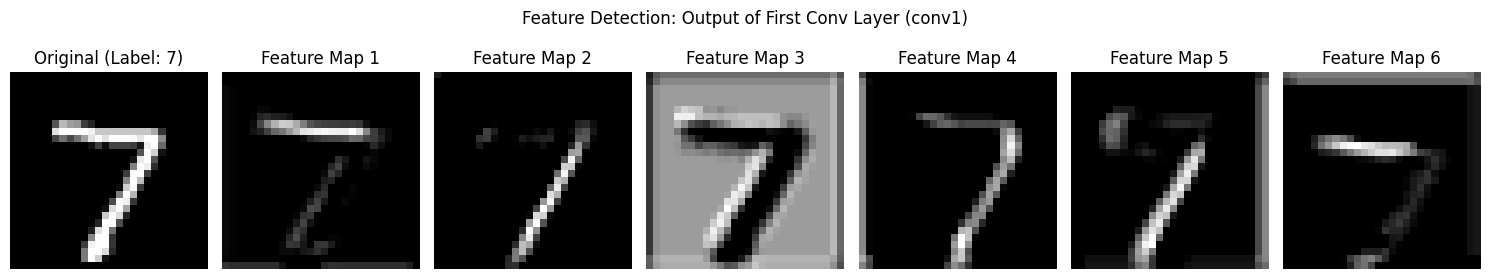

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import ssl # To disable SSL verification for dataset download if needed
ssl._create_default_https_context = ssl._create_unverified_context

# --- 1. Define the CNN Model ---
# This simple CNN will act as our feature detector
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        # Our first convolutional layer.
        # It takes 1 input channel (grayscale image)
        # It produces 6 output channels (6 feature maps)
        # It uses a 5x5 kernel (filter)
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5, stride=1, padding=2)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        # A second convolutional layer
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5, stride=1, padding=0)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        # Fully connected layers for classification
        self.fc1 = nn.Linear(16 * 5 * 5, 120) # 16 channels * 5x5 feature map size
        self.relu3 = nn.ReLU()
        self.fc2 = nn.Linear(120, 84)
        self.relu4 = nn.ReLU()
        self.fc3 = nn.Linear(84, 10) # 10 classes (digits 0-9)

    def forward(self, x):
        # Pass through conv1 -> relu -> pool
        x = self.pool1(self.relu1(self.conv1(x)))
        # Pass through conv2 -> relu -> pool
        x = self.pool2(self.relu2(self.conv2(x)))

        # Flatten the output for the fully connected layers
        x = x.view(-1, 16 * 5 * 5)

        # Pass through fully connected layers
        x = self.relu3(self.fc1(x))
        x = self.relu4(self.fc2(x))
        x = self.fc3(x)
        return x

    def get_features(self, x):
        """Helper function to get the output of the first conv layer."""
        # We only pass it through the first layer and its activation
        return self.relu1(self.conv1(x))

# --- 2. Set up Data, Model, Loss, and Optimizer ---

# Define transformations (convert to tensor and normalize)
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5,), (0.5,))])

# Download and load the training data
print("Downloading MNIST dataset...")
trainset = torchvision.datasets.MNIST(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64,
                                          shuffle=True)

# Download and load the test data
testset = torchvision.datasets.MNIST(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=64,
                                         shuffle=False)
print("Dataset loaded.")

# Initialize the model, loss function, and optimizer
model = SimpleCNN()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# --- 3. Train the Network (Abridged) ---
# Training is necessary for the filters (kernels) to learn
# meaningful patterns.
print("Training the model for 2 epochs...")
num_epochs = 2
for epoch in range(num_epochs):
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        if i % 200 == 199:    # print every 200 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 200:.3f}')
            running_loss = 0.0

print('Finished Training.')

# --- 4. Test the Network (Optional, but good practice) ---
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')

# --- 5. Detect and Visualize Features ---
print("\n--- Feature Detection Output ---")

# Get a single batch of test images
dataiter = iter(testloader)
images, labels = next(dataiter)

# Take the first image from the batch
img = images[0]
# Add a batch dimension (B, C, H, W) -> (1, 1, 28, 28)
img = img.unsqueeze(0)

# Get the label for the title
label = labels[0].item()

# Pass the image through the feature extractor
with torch.no_grad():
    feature_maps = model.get_features(img)

# --- 6. Print Output ---
print(f"Original Image Shape: {img.shape}")
print(f"Feature Maps Shape (Batch, Channels, Height, Width): {feature_maps.shape}")
print(f"This shows we have {feature_maps.shape[1]} feature maps for the single image.")

# --- 7. Visualize the Features ---
# Detach the feature maps from the computation graph and convert to numpy
feature_maps_np = feature_maps.squeeze(0).cpu().numpy()
img_np = img.squeeze(0).squeeze(0).cpu().numpy() # Remove batch and channel dims

# Create a plot
# We'll plot the original image and all 6 feature maps
num_features = feature_maps_np.shape[0]
fig, axes = plt.subplots(1, num_features + 1, figsize=(15, 3))

# Plot original image
axes[0].imshow(img_np, cmap='gray')
axes[0].set_title(f'Original (Label: {label})')
axes[0].axis('off')

# Plot feature maps
for i in range(num_features):
    axes[i+1].imshow(feature_maps_np[i], cmap='gray')
    axes[i+1].set_title(f'Feature Map {i+1}')
    axes[i+1].axis('off')

plt.suptitle('Feature Detection: Output of First Conv Layer (conv1)')
plt.tight_layout()

# Save the plot
output_filename = 'feature_maps.png'
plt.savefig(output_filename)
print(f"\nSaved visualization of feature maps to '{output_filename}'")
print("Check the file to see the detected features (e.g., edges, curves)!")